### Imports

In [129]:
import numpy as np
from math import pi
import scipy
import matplotlib.pyplot as plt

# Dirac Notation

### Functions for printing out the states

In [5]:
def PrettyPrintBinary(myState):
    retString = '( '
    for i in myState:
        retString += ( str(i[0]) + ' |' + i[1] + '> + ' )
    retString = retString[:-3]
    retString += ')'
    return retString

In [6]:
def PrettyPrintInteger(myState):
    retString = '( '
    for i in myState:
        retString += ( str(i[0]) + ' |' + str(int(i[1],2)) + '> + ' )
    retString = retString[:-3]
    retString += ')'
    return retString

In [7]:
def StateToVec(myState):
    max = 0
    for i in myState:
        if int(i[1],2) > max:
            max = int(i[1],2)
    vec = np.zeros(max+1, dtype = 'complex128')

    for i in myState:
        vec[int(i[1],2)] = i[0]
    return vec

In [8]:
def VecToState(myStateVec):
    retState = []
    iter = 0
    for i in myStateVec:
        if i != 0:
            retState.append((i,"{0:b}".format(iter)))
        iter += 1
    return retState

### Tests for Printing

In [9]:
myState2 = [
    (np.sqrt(.1)*1.j, '101'),
    (np.sqrt(.5), '000'),
    (-np.sqrt(.4), '010')
]

print(PrettyPrintBinary(myState2))
print(PrettyPrintInteger(myState2), '\n')

print(StateToVec(myState2))
print(VecToState(StateToVec(myState2)))

( 0.31622776601683794j |101> + 0.7071067811865476 |000> + -0.6324555320336759 |010>)
( 0.31622776601683794j |5> + 0.7071067811865476 |0> + -0.6324555320336759 |2>) 

[ 0.70710678+0.j          0.        +0.j         -0.63245553+0.j
  0.        +0.j          0.        +0.j          0.        +0.31622777j]
[((0.7071067811865476+0j), '0'), ((-0.6324555320336759+0j), '10'), (0.31622776601683794j, '101')]


# Quantum Simulator I

## Simulator 1.a

In [110]:
# Basic matrices
basicIdentity = np.array([[1, 0],[0, 1]])
basicHadamard = (1/np.sqrt(2))*np.array([[1, 1],[1, -1]])
basicCNOT = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
basicCNOTflip = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
print("Identity: \n", basicIdentity)
print("Hadamard: \n", basicHadamard)
print("CNOT: \n", basicCNOT)
print("CNOT Flip: \n", basicCNOTflip)

Identity: 
 [[1 0]
 [0 1]]
Hadamard: 
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
CNOT: 
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
CNOT Flip: 
 [[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


In [111]:
# Apples Hadamart to wire i out of k wire
def HadamardArray(i, k):
    myMatrix = np.array([1])
    for x in range(k):
        # If on wire 'i', apply Hadamard, else apply Identity
        if(x == i):
            myMatrix = np.kron(basicHadamard, myMatrix)
        else:
            myMatrix = np.kron(basicIdentity, myMatrix)

    return myMatrix
# print(HadamardArray(0,2)@ np.array([1,0,0,0]))
# print(HadamardArray(0,1) @ np.array([1,0]))

In [112]:
def PhaseArray(i, k, phi):
    myMatrix = np.array([1])
    basicPhase = np.array([[1, 0],[0, np.exp(complex(0,phi))]])
    for x in range(k):
        # If on wire 'i', apply Phase Gate, else apply Identity
        if(x == (i)):
            myMatrix = np.kron(basicPhase, myMatrix)
        else:
            myMatrix = np.kron(basicIdentity, myMatrix)
    return myMatrix
# print(PhaseArray(0,2,5.10940500719))
# print(PhaseArray(0,2,5.10940500719)@ np.array([1,1,0,0]))
# print(PhaseArray(0,1,5.10940500719) @ np.array([1,1]))

In [113]:
def CNOTArray(controlWire, otherWire, totalWire):
    myMatrix = np.array([1])
    x = 0
    while(x < totalWire):
        # If on wire 'i', apply Hadamard, else apply Identity
        if(x == controlWire):
            myMatrix = np.kron(basicCNOT, myMatrix)
            x += 1
        elif(x == otherWire): 
            myMatrix = np.kron(basicCNOTflip, myMatrix)
            x += 1
        else:
            myMatrix = np.kron(basicIdentity, myMatrix)
        x += 1
    #print(myMatrix)
    return myMatrix
#print(CNOTArray(1,0,2))
#print(CNOTArray(0,1,3)@ np.array([0,1,0,1,0,0,0,0]))
#print(CNOTArray(0,1,2) @ np.array([0,1,0,1]))

In [114]:
def ReadInput(fileName):
        myInput_lines=open(fileName).readlines()
        myInput=[]
        numberOfWires=int(myInput_lines[0])
        for line in myInput_lines[1:]:
            myInput.append(line.split())
        return (numberOfWires,myInput)

In [115]:
def readInitialState(filename):
    inputState = np.empty((0,0), dtype = 'complex128')
    lines = open(filename).readlines()
    for line in lines[0:]:
        num = line.split()
        inputState = np.append(inputState, complex(float(num[0]), float(num[1])))
    return inputState

# print(readInitialState("myInputState.txt"))

In [116]:
numberOfWires, myInput = ReadInput("input.circuit")
print(numberOfWires)
print(myInput[0][2])

5
myInputState.txt


In [117]:
def quantumCircuit1a(fileName):
    numberOfWires, myInput=ReadInput(fileName)
    
    # Generate circuit input
    if(myInput[0][0] == "INITSTATE"):
        inputState = readInitialState(myInput[0][2])
        ind_0 = 1
    else:
        # basis
        inputState = np.zeros(2**numberOfWires, dtype = "complex128")
        inputState[0] = 1
        ind_0 = 0        

    # Apply gates to input state
    U = np.identity(2**numberOfWires)
    for i in range(ind_0, len(myInput)):
        gate = myInput[i][0]
        if(gate == 'H'):
            wire = int(myInput[i][1])
            U = HadamardArray(wire, numberOfWires) @ U
        elif(gate == 'P'):
            wire = int(myInput[i][1])
            phase = float(myInput[i][2])
            U = PhaseArray(wire, numberOfWires, phase) @ U
        elif(gate == 'CNOT'):
            cwire = int(myInput[i][1])
            wire = int(myInput[i][2])
            U = CNOTArray(cwire, wire, numberOfWires) @ U
        elif(gate == "MEASURE"):
            plt.hist(measureVec(U @ inputState))
            plt.show()
    # return input state into the Unitary matrix
    return U @ inputState

In [118]:
def measureVec(vector):
    return vector.real**2 + vector.imag**2

### Testing for Simulator 1.a

In [119]:
result = quantumCircuit1a("rand.circuit")
print(PrettyPrintBinary(VecToState(result)))
#print(PrettyPrintBinary(VecToState(measureVec(result))))
#print(sum(measureVec(result)))

( (-0.014083322515851574+0.12361700437061857j) |0> + (0.10546650549095332+0.1511171265453809j) |1> + (-0.05320044270457744+0.21204952271866961j) |10> + (-0.03370685828137296+0.08313930949974177j) |11> + (-0.09789043986915626+0.00805147153006074j) |100> + (-0.10085285276296671+0.10484982364806525j) |101> + (0.033155808009031985-0.16613309200699633j) |110> + (0.022943819668955492-0.06562256598397503j) |111> + (0.07171228578151856-0.07704898190619977j) |1000> + (0.004174273783519236-0.155847916499092j) |1001> + (0.042148073942739485+0.15129692883364346j) |1010> + (0.008503597159646107+0.06388604907345147j) |1011> + (0.10282101832647528-0.1129873596582965j) |1100> + (0.0035214585533858054-0.22624793894946446j) |1101> + (0.20994091476876048-0.13239931902529495j) |1110> + (0.09286216596754185-0.041836678180953615j) |1111> + (0.15301130453905779+0.03530510774272079j) |10000> + (0.2045611865522816-0.1106907774541148j) |10001> + (0.2823951977679195+0.23148990870054992j) |10010> + (0.10156308689

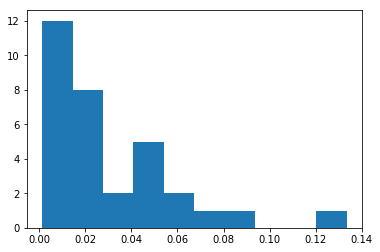

( 0.015479503742651021 |0> + 0.03395956971580595 |1> + 0.04779528718917861 |10> + 0.008048297079294412 |11> + 0.009647364411576275 |100> + 0.021164783429459023 |101> + 0.028699511864536897 |110> + 0.004832740027322706 |111> + 0.011079197544792089 |1000> + 0.024305997638727726 |1001> + 0.024667220811575206 |1010> + 0.00415373843086899 |1011> + 0.02333830525224661 |1100> + 0.05120053054922381 |1101> + 0.06160476737230578 |1110> + 0.010373689509399967 |1111> + 0.02465890994946941 |10000> + 0.05409772725707372 |10001> + 0.1333346255525713 |10010> + 0.022452353370240652 |10011> + 0.0035247886854053103 |10100> + 0.007732825876432493 |10101> + 0.0723830554369427 |10110> + 0.012188656412037428 |10111> + 0.027058045342989712 |11000> + 0.059361048808489116 |11001> + 0.008172330509897938 |11010> + 0.0013761470563719534 |11011> + 0.04176519823067409 |11100> + 0.09162620356498116 |11101> + 0.051282129389437575 |11110> + 0.008635449988015907 |11111>)


In [120]:
# measure.circuit
result = quantumCircuit1a("measure.circuit")
print(PrettyPrintBinary(VecToState(measureVec(result))))

In [121]:
# input.circuit
result = quantumCircuit1a("input.circuit")
print(PrettyPrintBinary(VecToState(measureVec(result)))) 
print(sum(measureVec(result)))

( 0.21216656404084494 |0> + 0.08132777675681205 |1> + 0.02200647235913622 |10> + 0.012615736658059262 |11> + 0.06493330392230691 |100> + 0.052124164397821846 |101> + 0.012544542559966707 |110> + 0.0029494512139599583 |111> + 0.05649802075492141 |1000> + 0.012438846261735357 |1001> + 0.042716561265688784 |1010> + 0.004707942820690924 |1011> + 0.008829060112935992 |1100> + 0.0022153912945678937 |1101> + 0.05031667580293355 |1110> + 0.0017873018290342037 |1111> + 0.004326766692975962 |10000> + 0.02623220090152875 |10001> + 0.01004464950822865 |10010> + 0.014078821666942779 |10011> + 0.033820058549507925 |10100> + 0.003335413433282539 |10101> + 0.047466546648073475 |10110> + 0.007364913193365203 |10111> + 0.021796012557434317 |11000> + 0.029625127236285055 |11001> + 0.040580117203822555 |11010> + 0.06390645331551946 |11011> + 0.009290187341343074 |11100> + 0.023741516837560855 |11101> + 0.01892945512076801 |11110> + 0.005283947741228972 |11111>)
0.9999999999992838


## Simulator 1.b

In [122]:

def quantumCircuit1b(fileName):
    numberOfWires, myInput=ReadInput(fileName)
    
    # Generate circuit input
    if(myInput[0][0] == "INITSTATE"):
        inputState = readInitialState(myInput[0][2])
        ind_0 = 1
    else:
        # basis
        inputState = np.zeros(2**numberOfWires, dtype = "complex128")
        inputState[0] = 1
        ind_0 = 0        

    # Apply gates to input state
    U = inputState
    for i in range(ind_0, len(myInput)):
        gate = myInput[i][0]
        if(gate == 'H'):
            wire = int(myInput[i][1])
            U = HadamardArray(wire, numberOfWires) @ U
        elif(gate == 'P'):
            wire = int(myInput[i][1])
            phase = float(myInput[i][2])
            U = PhaseArray(wire, numberOfWires, phase) @ U
        elif(gate == 'CNOT'):
            cwire = int(myInput[i][1])
            wire = int(myInput[i][2])
            U = CNOTArray(cwire, wire, numberOfWires) @ U
        elif(gate == "MEASURE"):
            plt.hist(measureVec(U))
            plt.show()
    # return input state into the Unitary matrix
    return U

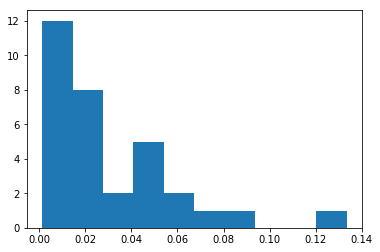

( 0.015479503742651037 |0> + 0.03395956971580595 |1> + 0.047795287189178616 |10> + 0.008048297079294425 |11> + 0.009647364411576277 |100> + 0.021164783429459044 |101> + 0.028699511864536918 |110> + 0.004832740027322715 |111> + 0.011079197544792104 |1000> + 0.024305997638727737 |1001> + 0.024667220811575206 |1010> + 0.004153738430868992 |1011> + 0.02333830525224661 |1100> + 0.05120053054922381 |1101> + 0.061604767372305816 |1110> + 0.010373689509399979 |1111> + 0.024658909949469423 |10000> + 0.054097727257073736 |10001> + 0.13333462555257125 |10010> + 0.022452353370240652 |10011> + 0.0035247886854053063 |10100> + 0.00773282587643249 |10101> + 0.07238305543694269 |10110> + 0.01218865641203743 |10111> + 0.02705804534298973 |11000> + 0.05936104880848915 |11001> + 0.008172330509897942 |11010> + 0.0013761470563719545 |11011> + 0.04176519823067408 |11100> + 0.09162620356498119 |11101> + 0.0512821293894376 |11110> + 0.008635449988015905 |11111>)


In [123]:
# measure.circuit
result = quantumCircuit1b("measure.circuit")
print(PrettyPrintBinary(VecToState(measureVec(result))))

In [124]:
result = quantumCircuit1a("input.circuit")
result2 = quantumCircuit1b("input.circuit")
print(sum(measureVec(result)) - sum(measureVec(result2)))

result = quantumCircuit1a("rand.circuit")
result2 = quantumCircuit1b("rand.circuit")
print(sum(measureVec(result)) - sum(measureVec(result2)))

# difference small enough to be explained by floating point innacurracies 

6.661338147750939e-16
-2.220446049250313e-16


## Simulator 1.c

In [130]:
#import scipy.sparse as sci
# Basic matrices
basicIdentity_csr = scipy.sparse.csr_matrix([[1, 0],[0, 1]])
basicHadamard_csr = (1/np.sqrt(2))*scipy.sparse.csr_matrix([[1, 1],[1, -1]])
basicCNOT_csr = scipy.sparse.csr_matrix([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
basicCNOTflip_csr = scipy.sparse.csr_matrix([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
print("Identity: \n", basicIdentity_csr.toarray())
print("Hadamard: \n", basicHadamard_csr.toarray())
print("CNOT: \n", basicCNOT_csr.toarray())
print("CNOT Flip: \n", basicCNOTflip_csr.toarray())


Identity: 
 [[1 0]
 [0 1]]
Hadamard: 
 [[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
CNOT: 
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
CNOT Flip: 
 [[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


In [131]:
# Apples Hadamart to wire i out of k wire
def HadamardArray_csr(i, k):
    myMatrix = scipy.sparse.csr_matrix([1])
    for x in range(k):
        # If on wire 'i', apply Hadamard, else apply Identity
        if(x == i):
            myMatrix = scipy.sparse.kron(basicHadamard_csr, myMatrix, format='csr')
        else:
            myMatrix = scipy.sparse.kron(basicIdentity_csr, myMatrix, format='csr')

    return myMatrix

def PhaseArray_csr(i, k, phi):
    myMatrix = scipy.sparse.csr_matrix([1])
    basicPhase_csr = scipy.sparse.csr_matrix([[1, 0],[0, np.exp(complex(0,phi))]])
    for x in range(k):
        # If on wire 'i', apply Phase Gate, else apply Identity
        if(x == (i)):
            myMatrix = scipy.sparse.kron(basicPhase_csr, myMatrix, format='csr')
        else:
            myMatrix = scipy.sparse.kron(basicIdentity_csr, myMatrix, format='csr')
    return myMatrix

def CNOTArray_csr(controlWire, otherWire, totalWire):
    myMatrix = scipy.sparse.csr_matrix([1])
    x = 0
    while(x < totalWire):
        # If on wire 'i', apply Hadamard, else apply Identity
        if(x == controlWire):
            myMatrix = scipy.sparse.kron(basicCNOT_csr, myMatrix, format='csr')
            x += 1
        elif(x == otherWire): 
            myMatrix = scipy.sparse.kron(basicCNOTflip_csr, myMatrix, format='csr')
            x += 1
        else:
            myMatrix = scipy.sparse.kron(basicIdentity_csr, myMatrix, format='csr')
        x += 1
    #print(myMatrix)
    return myMatrix


In [132]:
def quantumCircuit1c(fileName):
    numberOfWires, myInput=ReadInput(fileName)
    
    # Generate circuit input
    if(myInput[0][0] == "INITSTATE"):
        inputState = readInitialState(myInput[0][2])
        ind_0 = 1
    else:
        # basis
        inputState = np.zeros(2**numberOfWires, dtype = "complex128")
        inputState[0] = 1
        inputState = scipy.sparse.csr_matrix(inputState)
        ind_0 = 0        

    # Apply gates to input state
    U = scipy.sparse.csr_matrix(inputState)
    for i in range(ind_0, len(myInput)):
        gate = myInput[i][0]
        if(gate == 'H'):
            wire = int(myInput[i][1])
            U = U @ HadamardArray_csr(wire, numberOfWires)
        elif(gate == 'P'):
            wire = int(myInput[i][1])
            phase = float(myInput[i][2])
            U = U @ PhaseArray_csr(wire, numberOfWires, phase)
        elif(gate == 'CNOT'):
            cwire = int(myInput[i][1])
            wire = int(myInput[i][2])
            U = U @ CNOTArray_csr(cwire, wire, numberOfWires)
        elif(gate == "MEASURE"):
            plt.hist(measureVec(U.toarray()))
            plt.show()
    # return input state into the Unitary matrix
    return U.toarray()

In [133]:
result = quantumCircuit1a("input.circuit")
result2 = quantumCircuit1c("input.circuit")
print(np.sum(measureVec(result2)))
print(np.sum(result - result2))

result = quantumCircuit1a("rand.circuit")
result2 = quantumCircuit1c("rand.circuit")
print(np.sum(measureVec(result2)))
print(np.sum(result - result2))

# Differences so small they could reasonably be attributed to floating point precision error

0.9999999999992835
(-4.735795089416683e-16+6.938893903907228e-17j)
0.9999999999999958
(2.0686577451023425e-16-3.5561831257524545e-16j)


In [171]:
import time
time_ar = np.empty((0,0))
time_ar2 = np.empty((0,0))
time_ar3 = np.empty((0,0))

In [182]:
# Use this to append differnet qubit lengths
# Quantum Simulator I Graphing Time
st = time.time()
result = quantumCircuit1a("time.circuit")
elapsed = time.time() - st
print(elapsed)

time_ar = np.append(time_ar, elapsed)

st = time.time()
result = quantumCircuit1b("time.circuit")
elapsed = time.time() - st
print(elapsed)

time_ar2 = np.append(time_ar2, elapsed)

st = time.time()
result = quantumCircuit1c("time.circuit")
elapsed = time.time() - st
print(elapsed)

time_ar3 = np.append(time_ar3, elapsed)

15.584308624267578


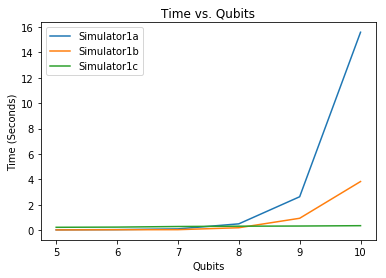

In [213]:
x = np.array([5,6,7,8,9,10])
plt.plot(x, time_ar, label = "Simulator1a")
plt.plot(x, time_ar2, label = "Simulator1b")
plt.plot(x, time_ar3, label = "Simulator1c")
plt.title("Time vs. Qubits")
plt.xlabel("Qubits")
plt.ylabel("Time (Seconds)")
plt.legend()
plt.show()

In [216]:
import psutil

In [217]:
print(psutil.virtual_memory())

svmem(total=8496750592, available=2503852032, percent=70.5, used=5992898560, free=2503852032)


In [237]:
ram_ar = np.array([29.1,28,32,38,47,90])
ram_ar2 = np.array([12.8,19.2,30,33,37,57])
ram_ar3 = np.array([8,7.9,17,15,20,18])

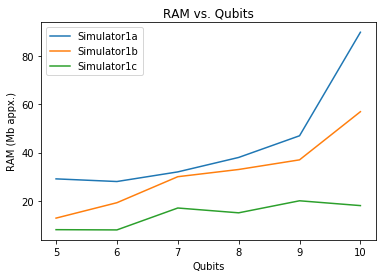

In [238]:
plt.plot(x, ram_ar, label = "Simulator1a")
plt.plot(x, ram_ar2, label = "Simulator1b")
plt.plot(x, ram_ar3, label = "Simulator1c")
plt.title("RAM vs. Qubits")
plt.xlabel("Qubits")
plt.ylabel("RAM (Mb appx.)")
plt.legend()
plt.show()

In [236]:
print(ram_ar, ram_ar2, ram_ar3)

[-8192.] [0.] [4096.]


# Simulator 2

In [ ]:
def Hadamard(inWire,numWires,inputState):
    inputVector = StateToVec(inputState)
    hadamardAr = HadamardArray(inWire, numWires)
    resultVec = hadamardAr @ inputVector
    resultState = VecToState(resultVec)
    return resultState

## Non-Atomic Gates

In [34]:
# Not Gate
basicPhase = np.array([[1, 0],[0, np.exp(complex(0,np.pi))]])
basicNot = basicHadamard @  basicPhase @ basicHadamard
print(basicNot)

# Basic test for document
PrettyPrintInteger(VecToState(basicNot @ np.array([0,1])))

[[-2.23711432e-17+6.123234e-17j  1.00000000e+00-6.123234e-17j]
 [ 1.00000000e+00-6.123234e-17j -2.23711432e-17+6.123234e-17j]]


'( (0.9999999999999998-6.123233995736765e-17j) |0> + (-2.2371143170757382e-17+6.123233995736765e-17j) |1>)'

In [90]:
# Rz Gate
def basicPhase(phi):
    return np.array([[1, 0],[0, np.exp(complex(0,phi))]])

def Rz(theta):
    return basicPhase(-1*theta/2) @ basicNot @ basicPhase(theta/2) @ basicNot

#print(basicPhase(1/2))
print(Rz(1))
#Rz(1)[0,0] + Rz(1)[1,1]

[[ 8.77582562e-01+4.79425539e-01j -7.13600159e-17+1.04243476e-16j]
 [-1.26473207e-17+1.25694071e-16j  8.77582562e-01-4.79425539e-01j]]


In [101]:
# testing
theta = 1
U = PhaseArray(0,2, 2*pi) @ CNOTArray(0,1,2) @ PhaseArray(0,2,2*pi) @ CNOTArray(0,1,2) #@ PhaseArray(0,2,np.pi)
U = (PhaseArray(0, 2, -1*theta/2)) @ (basicHadamard @  basicPhase @ basicHadamard) @ (basicPhase(theta/2)) @ (basicHadamard @  basicPhase @ basicHadamard) @ U

print(U)
# Control Rz Gate
#def controlRz(theta):
    




ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [109]:
# SWAP Gate
SWAP = basicCNOT @ basicCNOTflip @ basicCNOT
print(SWAP)

# SWAP(2,5)
swap25 = 


[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
